In [49]:
#数据准备
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from metpy import units
from netCDF4 import Dataset
import metpy.constants as constants
import metpy.calc as mpcalc
import cartopy.io.shapereader as shpreader
from matplotlib.path import Path
from cartopy.mpl.patch import geos_to_path
from metpy.interpolate import inverse_distance_to_grid
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
from scipy import stats
import scipy.ndimage as ndimage
from mpl_toolkits.basemap import Basemap
import time
from matplotlib.dates import DateFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
import cftime
import mpath
import matplotlib.path as mpath
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import os
import glob
import dask.array as da
import cmaps
import import_ipynb
from cartopy.util import add_cyclic_point
from matplotlib import rcParams
import sys
sys.path.append(r'C:\zjh\Python\jupyterProject\jupyterProject')
import code_study as cs
import datetime as dt
from datetime import timedelta
import calendar
from matplotlib.ticker import FixedLocator
from xinvert import invert_Poisson
# %run code_study.ipynb

In [50]:
def read_circulation(year,var):
    data_T=[]
    path_T="E:\\data\\ERA5.daily.1x1\\"+var+"\\"
    lat1=0
    lat2=90
    lon1=-180
    lon2=180
    lon_c=np.arange(-360,360,1)
    g=9.8 if var=='Z' else 1
    for i in range(5,15):
        if i<13:
            if i<10:
                uf1=xr.open_dataset(path_T+var+'.'+str(year)+'0'+str(i)+'.nc')[var].loc[:,500,lat1:lat2,:]/g
            else:
                uf1=xr.open_dataset(path_T+var+'.'+str(year)+str(i)+'.nc')[var].loc[:,500,lat1:lat2,:]/g
            if uf1.g0_lon_3[-1]>300:
                data_c=np.tile(uf1,(1,1,2))
                data_dac=xr.DataArray(data_c,coords=[uf1.initial_time0_hours,uf1.g0_lat_2,lon_c],dims=['initial_time0_hours','g0_lat_2','g0_lon_3'])
                data_T.append(data_dac.loc[:,:,lon1:lon2])
            else:
                uf1c,lonc=add_cyclic_point(uf1,coord=uf1.g0_lon_3, axis=-1)
                data_dac=xr.DataArray(uf1c,coords=[uf1.initial_time0_hours,uf1.g0_lat_2,lonc],dims=['initial_time0_hours','g0_lat_2','g0_lon_3'])
                data_T.append(data_dac.loc[:,:,lon1:lon2])
        else:
            uf1=xr.open_dataset(path_T+var+'.'+str(year+1)+'0'+str(i-12)+'.nc')[var].loc[:,500,lat1:lat2,:]/g
            if uf1.g0_lon_3[-1]>300:
                data_c=np.tile(uf1,(1,1,2))
                data_dac=xr.DataArray(data_c,coords=[uf1.initial_time0_hours,uf1.g0_lat_2,lon_c],dims=['initial_time0_hours','g0_lat_2','g0_lon_3'])
                data_T.append(data_dac.loc[:,:,lon1:lon2])
            else:
                uf1c,lonc=add_cyclic_point(uf1,coord=uf1.g0_lon_3, axis=-1)
                data_dac=xr.DataArray(uf1c,coords=[uf1.initial_time0_hours,uf1.g0_lat_2,lonc],dims=['initial_time0_hours','g0_lat_2','g0_lon_3'])
                data_T.append(data_dac.loc[:,:,lon1:lon2])
    T500=xr.concat(data_T,dim='initial_time0_hours')
    return T500

In [51]:
def climatology_all(lat1,lat2,lon1,lon2,year,allyear,var):
    path_dir=r'D:\data\Data_concat\climatology\moving climatology\\'+str(year)+'_'+var
    cs.mkdir_directory(path_dir)
    path=r'D:\data\Data_concat\climatology\moving climatology\\'+str(year)+'_'+var+'\\'+var+'_cli.nc'
    isExists=os.path.exists(path)
    if not isExists:
        files=glob.glob('E://data//ERA5.daily.1x1//'+var+'//'+var+'.*.nc')[12*(int(year)-1979-allyear)+3:12*(int(year)-1979)+3]
        data_scatter=[]
        lon_c=np.arange(-360,360,1)
        for file in files:  #按照顺序在 files 里面进行每一个文件的 数据名称 循环读取
            f=xr.open_dataset(file)  # 打开第一个文件
            if var=='Z':
                if f.g0_lon_3[-1]>300:
                    data_c=np.tile(f[var].loc[:,500,:,:],(1,1,2))
                    data_dac=xr.DataArray(data_c,coords=[f.initial_time0_hours,f.g0_lat_2,lon_c],dims=['initial_time0_hours','g0_lat_2','g0_lon_3'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]/9.8
                else:
                    uf1c,lonc=add_cyclic_point(f[var].loc[:,500,:,:],coord=f.g0_lon_3, axis=-1)
                    data_dac=xr.DataArray(uf1c,coords=[f.initial_time0_hours,f.g0_lat_2,lonc],dims=['initial_time0_hours','g0_lat_2','g0_lon_3'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]/9.8
            elif var=='U' or var=='V':
                if f.g0_lon_3[-1]>300:
                    data_c=np.tile(f[var].loc[:,500,:,:],(1,1,2))
                    data_dac=xr.DataArray(data_c,coords=[f.initial_time0_hours,f.g0_lat_2,lon_c],dims=['initial_time0_hours','g0_lat_2','g0_lon_3'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]
                else:
                    uf1c,lonc=add_cyclic_point(f[var].loc[:,500,:,:],coord=f.g0_lon_3, axis=-1)
                    data_dac=xr.DataArray(uf1c,coords=[f.initial_time0_hours,f.g0_lat_2,lonc],dims=['initial_time0_hours','g0_lat_2','g0_lon_3'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]
            else:
                if f.g0_lon_2[-1]>300:
                    data_c=np.tile(f[var],(1,1,2))
                    data_dac=xr.DataArray(data_c,coords=[f.initial_time0_hours,f.g0_lat_1,lon_c],dims=['initial_time0_hours','g0_lat_1','g0_lon_2'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]   
                else:
                    uf1c,lonc=add_cyclic_point(f[var],coord=f.g0_lon_2, axis=-1)
                    data_dac=xr.DataArray(uf1c,coords=[f.initial_time0_hours,f.g0_lat_1,lonc],dims=['initial_time0_hours','g0_lat_1','g0_lon_2'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]
            data_scatter.append(t0)
        t1=xr.concat(data_scatter,dim='initial_time0_hours')
        mask=(t1.initial_time0_hours.dt.month.isin([2])&t1.initial_time0_hours.dt.day.isin([29]))
        t=t1.loc[~mask]
        if var=='Z' or var=='U' or var=='V':
            lat=t.g0_lat_2.loc[lat1:lat2]
            lon=t.g0_lon_3.loc[lon1:lon2]
        else:
            lat=t.g0_lat_1.loc[lat1:lat2]
            lon=t.g0_lon_2.loc[lon1:lon2]
        t_cli=t.values.reshape(allyear,365,len(lat),len(lon))
        time=pd.date_range('2010-04-01','2011-03-31',freq='D')
        t_cli_nc=xr.DataArray(t_cli,coords=[np.arange(allyear),time,lat,lon],dims=['year','time','lat','lon'],name=var+'_cli')
        t_cli_nc.to_netcdf(path)
    elif var=='Z':
        t_cli_nc=xr.open_dataset(path).Z_cli
    elif var=='U':
        t_cli_nc=xr.open_dataset(path).U_cli
    elif var=='V':
        t_cli_nc=xr.open_dataset(path).V_cli
    else:
        t_cli_nc=xr.open_dataset(path).T2m_cli
    return t_cli_nc

In [52]:
def vorticity_forcing(U_ano,V_ano):
    re = 6371000
    delta_lat = 2.5
    lat=np.arange(0,80.1,2.5)
    lon=np.arange(-180,180.1,2.5)
    radians_lat=np.radians(delta_lat)
    dx= re * radians_lat * np.cos(np.radians(lat))
    dy= re * radians_lat
    # vorticity=np.gradient(V_ano,axis=2)/(np.array(dx)[np.newaxis,:,np.newaxis])-np.gradient(U_ano,axis=1)/(np.array(dy))
    U_ano.attrs["units"] = "m/s"
    V_ano.attrs["units"] = "m/s"
    vorticity=mpcalc.vorticity(U_ano,V_ano)
    vorticity_advection=U_ano*np.gradient(vorticity,axis=2)/(np.array(dx)[np.newaxis,:,np.newaxis])+V_ano*np.gradient(vorticity,axis=1)/(np.array(dy))
    iParams={
    'BCs':['fixed','periodic'],
    'mxLoop':600,
    'tolerance':1e-5,
    'optArg':1.4,
    }
    psi=invert_Poisson(-vorticity_advection,dims=['lat','lon'],iParams=iParams)
    return vorticity_advection,psi

In [53]:
# iy,cliyears,startdate0,enddate0=2020,20,'2020-12-01','2020-12-18'
# day_ahead=0
# startdate=(dt.datetime.strptime(startdate0,'%Y-%m-%d')-pd.Timedelta(days=day_ahead)).strftime('%Y-%m-%d')
# enddate=(dt.datetime.strptime(enddate0,'%Y-%m-%d')-pd.Timedelta(days=day_ahead)).strftime('%Y-%m-%d')
# startdate=(pd.to_datetime(enddate)-timedelta(days=23)).strftime('%Y-%m-%d')
# event_days=(dt.datetime.strptime(enddate,'%Y-%m-%d')-dt.datetime.strptime(startdate,'%Y-%m-%d')).days+1
# # eventweek=(event_days+3)//7
# # extrs_last_week=event_days-eventweek*7
# # vor_f,vor_f_all,p_vor_f=[[] for i in range(4)],[[] for i in range(4)],[[] for i in range(4)]
# # vorticity_adv,vorticity_adv_all=[[] for i in range(4)],[[] for i in range(4)]
# vor_f,vor_f_all=[],[]
# vorticity_adv,vorticity_adv_all=[],[]
# lat1,lat2,lon1,lon2=0,80,-180,180
# lat_25=np.arange(lat1,lat2+1,2.5)
# lon_25=np.arange(lon1,lon2+1,2.5)
# Z_cli_all_2022=climatology_all(lat1,lat2,lon1,lon2,iy,cliyears,'Z')
# Z_cli_2022=Z_cli_all_2022.mean(dim='year')
# U_cli_all_2022=climatology_all(lat1,lat2,lon1,lon2,iy,cliyears,'U')
# U_cli_2022=U_cli_all_2022.mean(dim='year')
# V_cli_all_2022=climatology_all(lat1,lat2,lon1,lon2,iy,cliyears,'V')
# V_cli_2022=V_cli_all_2022.mean(dim='year')
# if int(startdate[5:7]) >3:
#     startdate1='2010'
# else:
#     startdate1='2011'
# if int(enddate[5:7]) >3:
#     enddate1='2010'
# else:
#     enddate1='2011'
# U_real=read_circulation(iy,'U').loc[startdate:enddate].interp(g0_lat_2=lat_25,g0_lon_3=lon_25)
# U_cli_event=U_cli_2022.loc[startdate1+startdate[4:]:enddate1+enddate[4:]].interp(lat=lat_25,lon=lon_25)
# U_cli_all_2022_event=U_cli_all_2022.sel(time=slice(startdate1+startdate[4:],enddate1+enddate[4:])).interp(lat=lat_25,lon=lon_25)
# V_real=read_circulation(iy,'V').loc[startdate:enddate].interp(g0_lat_2=lat_25,g0_lon_3=lon_25)
# V_cli_event=V_cli_2022.loc[startdate1+startdate[4:]:enddate1+enddate[4:]].interp(lat=lat_25,lon=lon_25)
# V_cli_all_2022_event=V_cli_all_2022.sel(time=slice(startdate1+startdate[4:],enddate1+enddate[4:])).interp(lat=lat_25,lon=lon_25)
# U_ano=U_real.values-U_cli_event
# V_ano=V_real.values-V_cli_event
# U_ano_all=U_cli_all_2022_event-U_cli_event
# V_ano_all=V_cli_all_2022_event-V_cli_event
# vorticity_adv,vor_f=vorticity_forcing(U_ano,V_ano)
# # for i in range(len(U_ano_all)):
# #     v_adv_all,v_f_all=vorticity_forcing(U_ano_all[i],V_ano_all[i])
# #     vorticity_adv_all.append(v_adv_all)
# #     vor_f_all.append(v_f_all)        

In [54]:
# iy,cliyears,startdate0,enddate0=2020,20,'2020-12-01','2020-12-18'
def calculate_vf_ERA5(iy,cliyears,startdate0,enddate0):
    day_ahead=0
    startdate=(dt.datetime.strptime(startdate0,'%Y-%m-%d')-pd.Timedelta(days=day_ahead)).strftime('%Y-%m-%d')
    enddate=(dt.datetime.strptime(enddate0,'%Y-%m-%d')-pd.Timedelta(days=day_ahead)).strftime('%Y-%m-%d')
    startdate=(pd.to_datetime(enddate)-timedelta(days=23)).strftime('%Y-%m-%d')
    event_days=(dt.datetime.strptime(enddate,'%Y-%m-%d')-dt.datetime.strptime(startdate,'%Y-%m-%d')).days+1
    # eventweek=(event_days+3)//7
    # extrs_last_week=event_days-eventweek*7
    # vor_f,vor_f_all,p_vor_f=[[] for i in range(4)],[[] for i in range(4)],[[] for i in range(4)]
    # vorticity_adv,vorticity_adv_all=[[] for i in range(4)],[[] for i in range(4)]
    vor_f,vor_f_all=[],[]
    lat1,lat2,lon1,lon2=0,80,-180,180
    lat_25=np.arange(lat1,lat2+1,2.5)
    lon_25=np.arange(lon1,lon2+1,2.5)
    Z_cli_all_2022=climatology_all(lat1,lat2,lon1,lon2,iy,cliyears,'Z')
    Z_cli_2022=Z_cli_all_2022.mean(dim='year')
    U_cli_all_2022=climatology_all(lat1,lat2,lon1,lon2,iy,cliyears,'U')
    U_cli_2022=U_cli_all_2022.mean(dim='year')
    V_cli_all_2022=climatology_all(lat1,lat2,lon1,lon2,iy,cliyears,'V')
    V_cli_2022=V_cli_all_2022.mean(dim='year')
    if int(startdate[5:7]) >3:
        startdate1='2010'
    else:
        startdate1='2011'
    if int(enddate[5:7]) >3:
        enddate1='2010'
    else:
        enddate1='2011'
    U_real=read_circulation(iy,'U').loc[startdate:enddate].interp(g0_lat_2=lat_25,g0_lon_3=lon_25)
    U_cli_event=U_cli_2022.loc[startdate1+startdate[4:]:enddate1+enddate[4:]].interp(lat=lat_25,lon=lon_25)
    U_cli_all_2022_event=U_cli_all_2022.sel(time=slice(startdate1+startdate[4:],enddate1+enddate[4:])).interp(lat=lat_25,lon=lon_25)
    V_real=read_circulation(iy,'V').loc[startdate:enddate].interp(g0_lat_2=lat_25,g0_lon_3=lon_25)
    V_cli_event=V_cli_2022.loc[startdate1+startdate[4:]:enddate1+enddate[4:]].interp(lat=lat_25,lon=lon_25)
    V_cli_all_2022_event=V_cli_all_2022.sel(time=slice(startdate1+startdate[4:],enddate1+enddate[4:])).interp(lat=lat_25,lon=lon_25)
    U_ano=U_real.values-U_cli_event
    V_ano=V_real.values-V_cli_event
    U_ano_all=U_cli_all_2022_event-U_cli_event
    V_ano_all=V_cli_all_2022_event-V_cli_event
    vorticity_adv,vor_f=vorticity_forcing(U_ano,V_ano)
    # for i in range(len(U_ano_all)):
    #     v_adv_all,v_f_all=vorticity_forcing(U_ano_all[i],V_ano_all[i])
    #     vorticity_adv_all.append(v_adv_all)
    #     vor_f_all.append(v_f_all)       
    return vor_f,vor_f_all
        

In [55]:
def s2s_dataread(forecast_day,model,lat1,lat2,lon1,lon2,var):
    if var=='Z':
        vname='gh'
    elif var=='U':
        vname='u'
    elif var=='V':
        vname='v'
    dataset_Z=xr.open_dataset(r'D:\data\S2S_data\Blocking_classify\\'+model+'\\Realtime\\'+var+'.'+str(forecast_day)+'.grib',engine='cfgrib').sel(isobaricInhPa=500)
    Z=dataset_Z[vname].loc[:,lat1:lat2,:][:,::-1,:]
    
    dataset_ptZ=xr.open_dataset(r'D:\data\S2S_data\Blocking_classify\\'+model+'\\Realtime\PT'+var+'.'+str(forecast_day)+'.grib',engine='cfgrib').sel(isobaricInhPa=500)
    ptZ=dataset_ptZ[vname].loc[:,:,lat1:lat2,:][:,:,::-1,:]
    ptZ_all=xr.concat([Z,ptZ],dim='number')
    
    dataset_reZ=xr.open_dataset(r'D:\data\S2S_data\Blocking_classify\\'+model+'\\reforecast\\'+var+'.'+str(forecast_day)+'.grib',engine='cfgrib').sel(isobaricInhPa=500)
    dataset_reptZ=xr.open_dataset(r'D:\data\S2S_data\Blocking_classify\\'+model+'\\reforecast\PT'+var+'.'+str(forecast_day)+'.grib',engine='cfgrib').sel(isobaricInhPa=500)
    reZ_all=xr.concat([dataset_reZ[vname].loc[:,:,lat1:lat2,:][:,:,::-1,:],dataset_reptZ[vname].loc[:,:,:,lat1:lat2,:][:,:,:,::-1,:]],dim='number')
    
    return ptZ_all,reZ_all

In [56]:
# forecast_day,model='20201123','ECMWF'
# vor_f,vor_f_all,p_vor_f=[[] for i in range(4)],[[] for i in range(4)],[[] for i in range(4)]
# vorticity_adv,vorticity_adv_all=[[] for i in range(4)],[[] for i in range(4)]
# latf1=80
# latf2=0
# lonf1=0
# lonf2=360    
# lat=np.arange(latf2,latf1+1,2.5)
# lon=np.arange(-180,181,2.5)
# ptU500_mean,reU500_cli_all=s2s_dataread(forecast_day,model,latf1,latf2,lonf1,lonf2,'U')
# ptV500_mean,reV500_cli_all=s2s_dataread(forecast_day,model,latf1,latf2,lonf1,lonf2,'V')
# reU500_cli=reU500_cli_all.mean(dim='number').mean(dim='time')
# reV500_cli=reV500_cli_all.mean(dim='number').mean(dim='time')
# 
# ptU500_ano=ptU500_mean-reU500_cli
# ptV500_ano=ptV500_mean-reV500_cli
# ptU500_ano_cli=reU500_cli_all-reU500_cli
# ptV500_ano_cli=reV500_cli_all-reV500_cli
# ptU500_ano_c0=cs.conver_lon(ptU500_ano,'longitude').loc[:,:,-180:180].transpose('number','step','latitude','longitude')
# ptV500_ano_c0=cs.conver_lon(ptV500_ano,'longitude').loc[:,:,-180:180].transpose('number','step','latitude','longitude')
# ptU500_ano_cli_c0=cs.conver_lon(ptU500_ano_cli,'longitude').loc[:,:,:,-180:180].transpose('number','step','time','latitude','longitude')
# ptV500_ano_cli_c0=cs.conver_lon(ptV500_ano_cli,'longitude').loc[:,:,:,-180:180].transpose('number','step','time','latitude','longitude')
# # reU500_all_c=cs.conver_lon(reU500_cli_all,'longitude').loc[:,:,:,-180:180].transpose('number','step','time','latitude','longitude')
# # reV500_all_c=cs.conver_lon(reV500_cli_all,'longitude').loc[:,:,:,-180:180].transpose('number','step','time','latitude','longitude')
# ptU500_ano_c=np.insert(ptU500_ano_c0, 0,ptU500_ano_c0.sel(longitude=180).values,axis=3).mean(dim='number')
# ptV500_ano_c=np.insert(ptV500_ano_c0, 0,ptV500_ano_c0.sel(longitude=180).values,axis=3).mean(dim='number')
# ptU500_ano_da=xr.DataArray(ptU500_ano_c.values,coords=[ptU500_ano_c['valid_time'],lat,lon],dims=['time','lat','lon'])
# ptV500_ano_da=xr.DataArray(ptV500_ano_c.values,coords=[ptV500_ano_c['valid_time'],lat,lon],dims=['time','lat','lon'])
# # ptU500_ano_cli_c=np.insert(ptU500_ano_cli_c0, 0,ptU500_ano_cli_c0.sel(longitude=180).values,axis=4)
# # ptV500_ano_cli_c=np.insert(ptV500_ano_cli_c0, 0,ptV500_ano_cli_c0.sel(longitude=180).values,axis=4)
# vorticity_adv,vor_f=vorticity_forcing(ptU500_ano_da,ptV500_ano_da)

In [57]:
def calculate_vf_Dynamic_model(forecast_day,model):
    vor_f,vor_f_all,p_vor_f=[[] for i in range(4)],[[] for i in range(4)],[[] for i in range(4)]
    vorticity_adv,vorticity_adv_all=[[] for i in range(4)],[[] for i in range(4)]
    latf1=80
    latf2=0
    lonf1=0
    lonf2=360    
    lat=np.arange(latf2,latf1+1,2.5)
    lon=np.arange(-180,181,2.5)
    ptU500_mean,reU500_cli_all=s2s_dataread(forecast_day,model,latf1,latf2,lonf1,lonf2,'U')
    ptV500_mean,reV500_cli_all=s2s_dataread(forecast_day,model,latf1,latf2,lonf1,lonf2,'V')
    reU500_cli=reU500_cli_all.mean(dim='number').mean(dim='time')
    reV500_cli=reV500_cli_all.mean(dim='number').mean(dim='time')
    
    ptU500_ano=ptU500_mean-reU500_cli
    ptV500_ano=ptV500_mean-reV500_cli
    ptU500_ano_cli=reU500_cli_all-reU500_cli
    ptV500_ano_cli=reV500_cli_all-reV500_cli
    ptU500_ano_c0=cs.conver_lon(ptU500_ano,'longitude').loc[:,:,-180:180].transpose('number','step','latitude','longitude')
    ptV500_ano_c0=cs.conver_lon(ptV500_ano,'longitude').loc[:,:,-180:180].transpose('number','step','latitude','longitude')
    ptU500_ano_cli_c0=cs.conver_lon(ptU500_ano_cli,'longitude').loc[:,:,:,-180:180].transpose('number','step','time','latitude','longitude')
    ptV500_ano_cli_c0=cs.conver_lon(ptV500_ano_cli,'longitude').loc[:,:,:,-180:180].transpose('number','step','time','latitude','longitude')
    # reU500_all_c=cs.conver_lon(reU500_cli_all,'longitude').loc[:,:,:,-180:180].transpose('number','step','time','latitude','longitude')
    # reV500_all_c=cs.conver_lon(reV500_cli_all,'longitude').loc[:,:,:,-180:180].transpose('number','step','time','latitude','longitude')
    ptU500_ano_c=np.insert(ptU500_ano_c0, 0,ptU500_ano_c0.sel(longitude=180).values,axis=3).mean(dim='number')
    ptV500_ano_c=np.insert(ptV500_ano_c0, 0,ptV500_ano_c0.sel(longitude=180).values,axis=3).mean(dim='number')
    ptU500_ano_da=xr.DataArray(ptU500_ano_c.values,coords=[ptU500_ano_c['valid_time'],lat,lon],dims=['time','lat','lon'])
    ptV500_ano_da=xr.DataArray(ptV500_ano_c.values,coords=[ptV500_ano_c['valid_time'],lat,lon],dims=['time','lat','lon'])
    # ptU500_ano_cli_c=np.insert(ptU500_ano_cli_c0, 0,ptU500_ano_cli_c0.sel(longitude=180).values,axis=4)
    # ptV500_ano_cli_c=np.insert(ptV500_ano_cli_c0, 0,ptV500_ano_cli_c0.sel(longitude=180).values,axis=4)
    vorticity_adv,vor_f=vorticity_forcing(ptU500_ano_da,ptV500_ano_da)
   
    return vor_f,vor_f_all

In [65]:
event_date='2020-12-01'
event_date_end='2020-12-18'
event_forecast_date=['20201116','20201119','20201123']
model='ECMWF'
ERA5_date_24=(pd.to_datetime(event_date_end)-timedelta(days=23)).strftime('%Y-%m-%d')
vor_f_ECMWF=[]
vor_f_ERA5,_=calculate_vf_ERA5(int(ERA5_date_24[:4]),20,event_date,event_date_end)
vor_f_ERA5=vor_f_ERA5.sel(lon=slice(-60,150))
for ft in event_forecast_date:
    v_f_EC,_=calculate_vf_Dynamic_model(ft,model)
    vor_f_ECMWF.append(v_f_EC.sel(time=slice(ERA5_date_24,event_date_end),lon=slice(-60,150)))

{time: 2010-11-25T00:00:00} loops  600 and tolerance is 1.839965e-04
{time: 2010-11-26T00:00:00} loops  600 and tolerance is 5.031551e-05
{time: 2010-11-27T00:00:00} loops  600 and tolerance is 9.297563e-05
{time: 2010-11-28T00:00:00} loops  600 and tolerance is 4.953110e-05
{time: 2010-11-29T00:00:00} loops  600 and tolerance is 3.377451e-05
{time: 2010-11-30T00:00:00} loops  600 and tolerance is 1.548249e-04
{time: 2010-12-01T00:00:00} loops  600 and tolerance is 8.591710e-05
{time: 2010-12-02T00:00:00} loops  582 and tolerance is 9.947518e-06
{time: 2010-12-03T00:00:00} loops  600 and tolerance is 2.999574e-05
{time: 2010-12-04T00:00:00} loops  510 and tolerance is 9.947363e-06
{time: 2010-12-05T00:00:00} loops  600 and tolerance is 5.685861e-05
{time: 2010-12-06T00:00:00} loops  600 and tolerance is 4.452548e-05
{time: 2010-12-07T00:00:00} loops  600 and tolerance is 1.962508e-04
{time: 2010-12-08T00:00:00} loops  600 and tolerance is 1.217002e-04
{time: 2010-12-09T00:00:00} loops 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


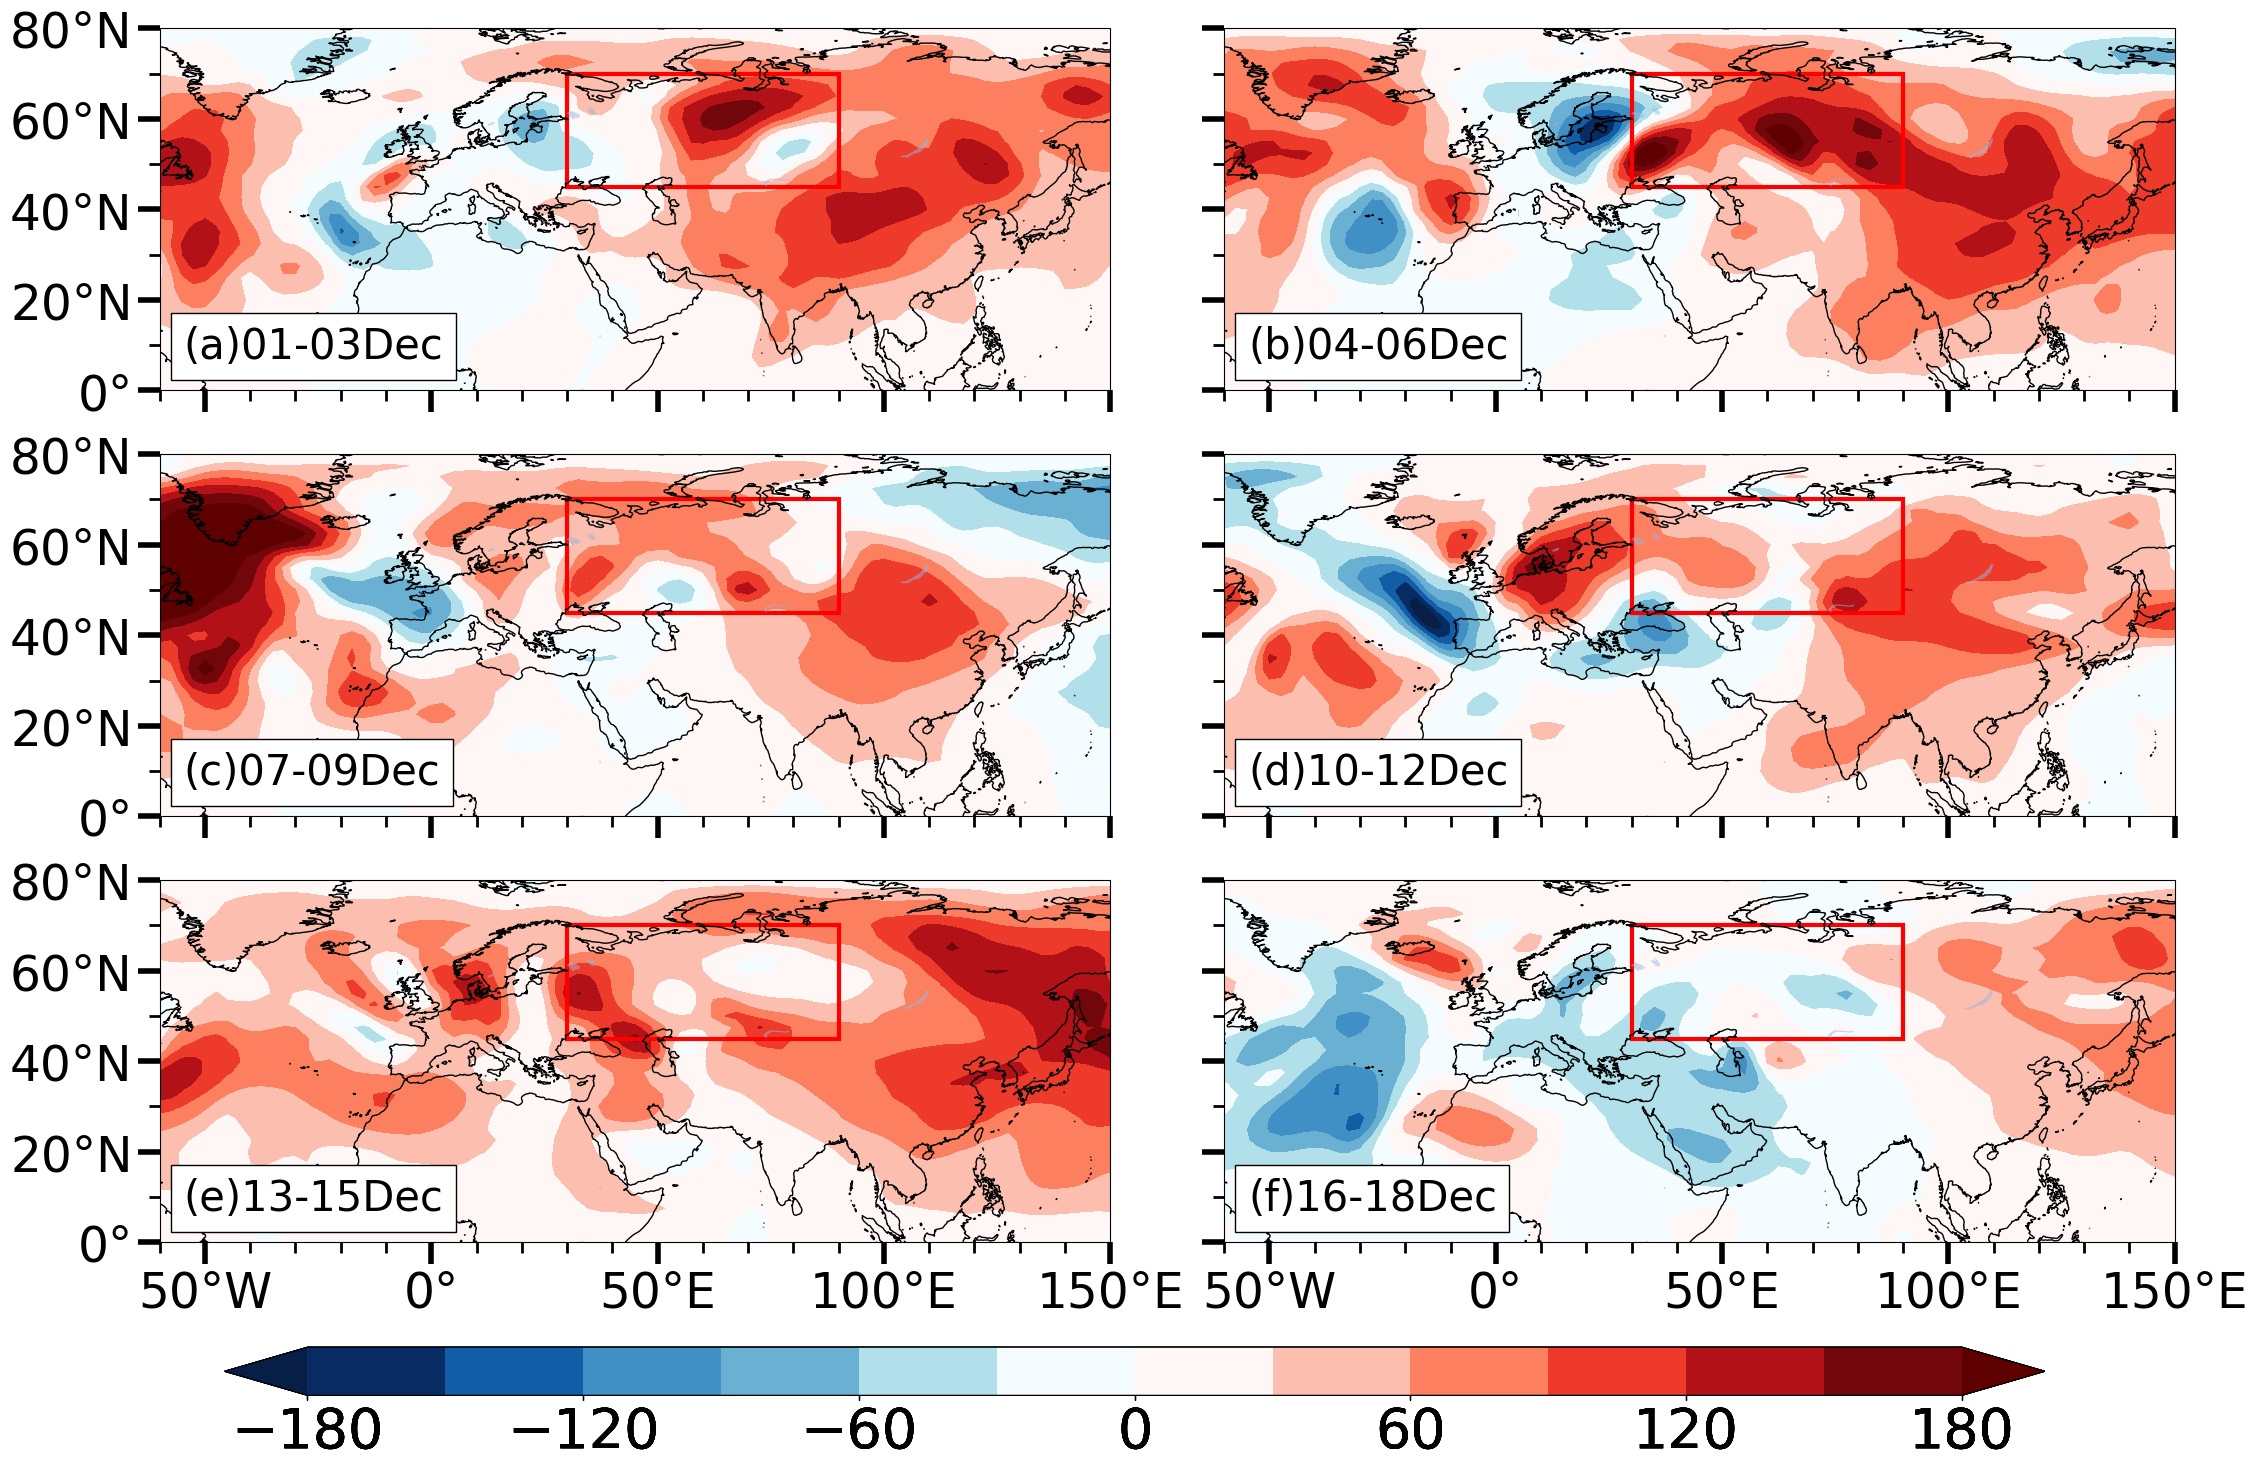

In [85]:
text_date=['01-03Dec','04-06Dec','07-09Dec','10-12Dec','13-15Dec','16-18Dec']
fig=plt.figure(figsize=(26,16))
plt.subplots_adjust(wspace=0.12,hspace=0.12)
for i in range(6):
    ax = fig.add_subplot(3,2,i+1,projection = ccrs.PlateCarree())
    text='('+chr(ord('a') + i)+')'+text_date[i]
    props = dict(boxstyle="square,pad=0.3",edgecolor="black", facecolor="white", alpha=1)  # 设置文本框样式  pad=0.2为字体距边框距离
    ax.text(
        0.025, 0.18,  # 文本框位置（相对坐标，左下角）
        text,
        fontsize=30,  # 字体大小
        color="black",  # 字体颜色
        bbox=props,
        transform=ax.transAxes,  # 使用相对坐标
        verticalalignment="top",  # 垂直对齐方式，顶部对齐
        horizontalalignment="left",  # 水平对齐方式，左对齐
        zorder=2
    )
    ax.add_feature(cfeature.COASTLINE.with_scale('50m')) 
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.set_xticks(np.array([20,60,100,140,180]), crs=ccrs.PlateCarree())
    ax.set_yticks(np.array([20,40,60,80]), crs=ccrs.PlateCarree())
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.xaxis.set_major_locator(FixedLocator(np.arange(-50,151,50)))    
    ax.xaxis.set_minor_locator(MultipleLocator(10)) 
    ax.yaxis.set_major_locator(FixedLocator(np.arange(0,81,20)))    
    ax.yaxis.set_minor_locator(MultipleLocator(10)) 
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis="x", which="major", direction="out", width=4, length=16,labelsize=35)
    ax.tick_params(axis='x', which="minor", direction="out", width=2, length=8)
    ax.tick_params(axis="y", which="major", direction="out", width=4, length=16,labelsize=35)
    ax.tick_params(axis='y', which="minor", direction="out", width=2, length=8)
    if i>3:
        ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    if i % 2==0:
        ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    cs.draw_rectangle(30,90,45,70,ax)
    # black_rectangle(1,60,21,50,ax)
    import cmaps
    cmap1=cmaps.BlueWhiteOrangeRed
    cmap=cmaps.BlueYellowRed
    temperature_cmap = cmaps.temp_19lev
    # 获取该色图的颜色
    colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))
    
    # 让中间两个颜色成为白色
    midpoint = len(colors) // 2  # 找到色图的中间位置
    colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色
    
    # 创建新的色图
    new_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)
    lon=np.arange(-60,151,2.5)
    lat=np.arange(0,81,2.5)
    c1 = ax.contourf(lon,lat, vor_f_ERA5[3*i:3*(i+1)].mean(dim='time'), zorder=0,levels =np.arange(-180,181,30) ,
                         transform=ccrs.PlateCarree(), cmap=new_cmap,extend='both')
    # C2 = ax.contour(lon,lat, Z_ano_all_event, zorder=0,levels =np.arange(-160,0,10),linestyles='--',colors='black',linewidths=2)
    # C3 = ax.contour(lon,lat, Z_ano_all_event, zorder=0,levels =np.arange(10,161,10),linestyles='-',colors='black',linewidths=2)
    
    position=fig.add_axes([0.15, 0.02,  0.7, 0.03])
    cb = plt.colorbar(c1,cax=position,fraction=0.032, pad=0.2,orientation='horizontal')
    cb.ax.tick_params(labelsize=40)
    cb.set_ticks(np.arange(-180,181,60))
    
cs.mkdir_directory(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'.eps',dpi=300,bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


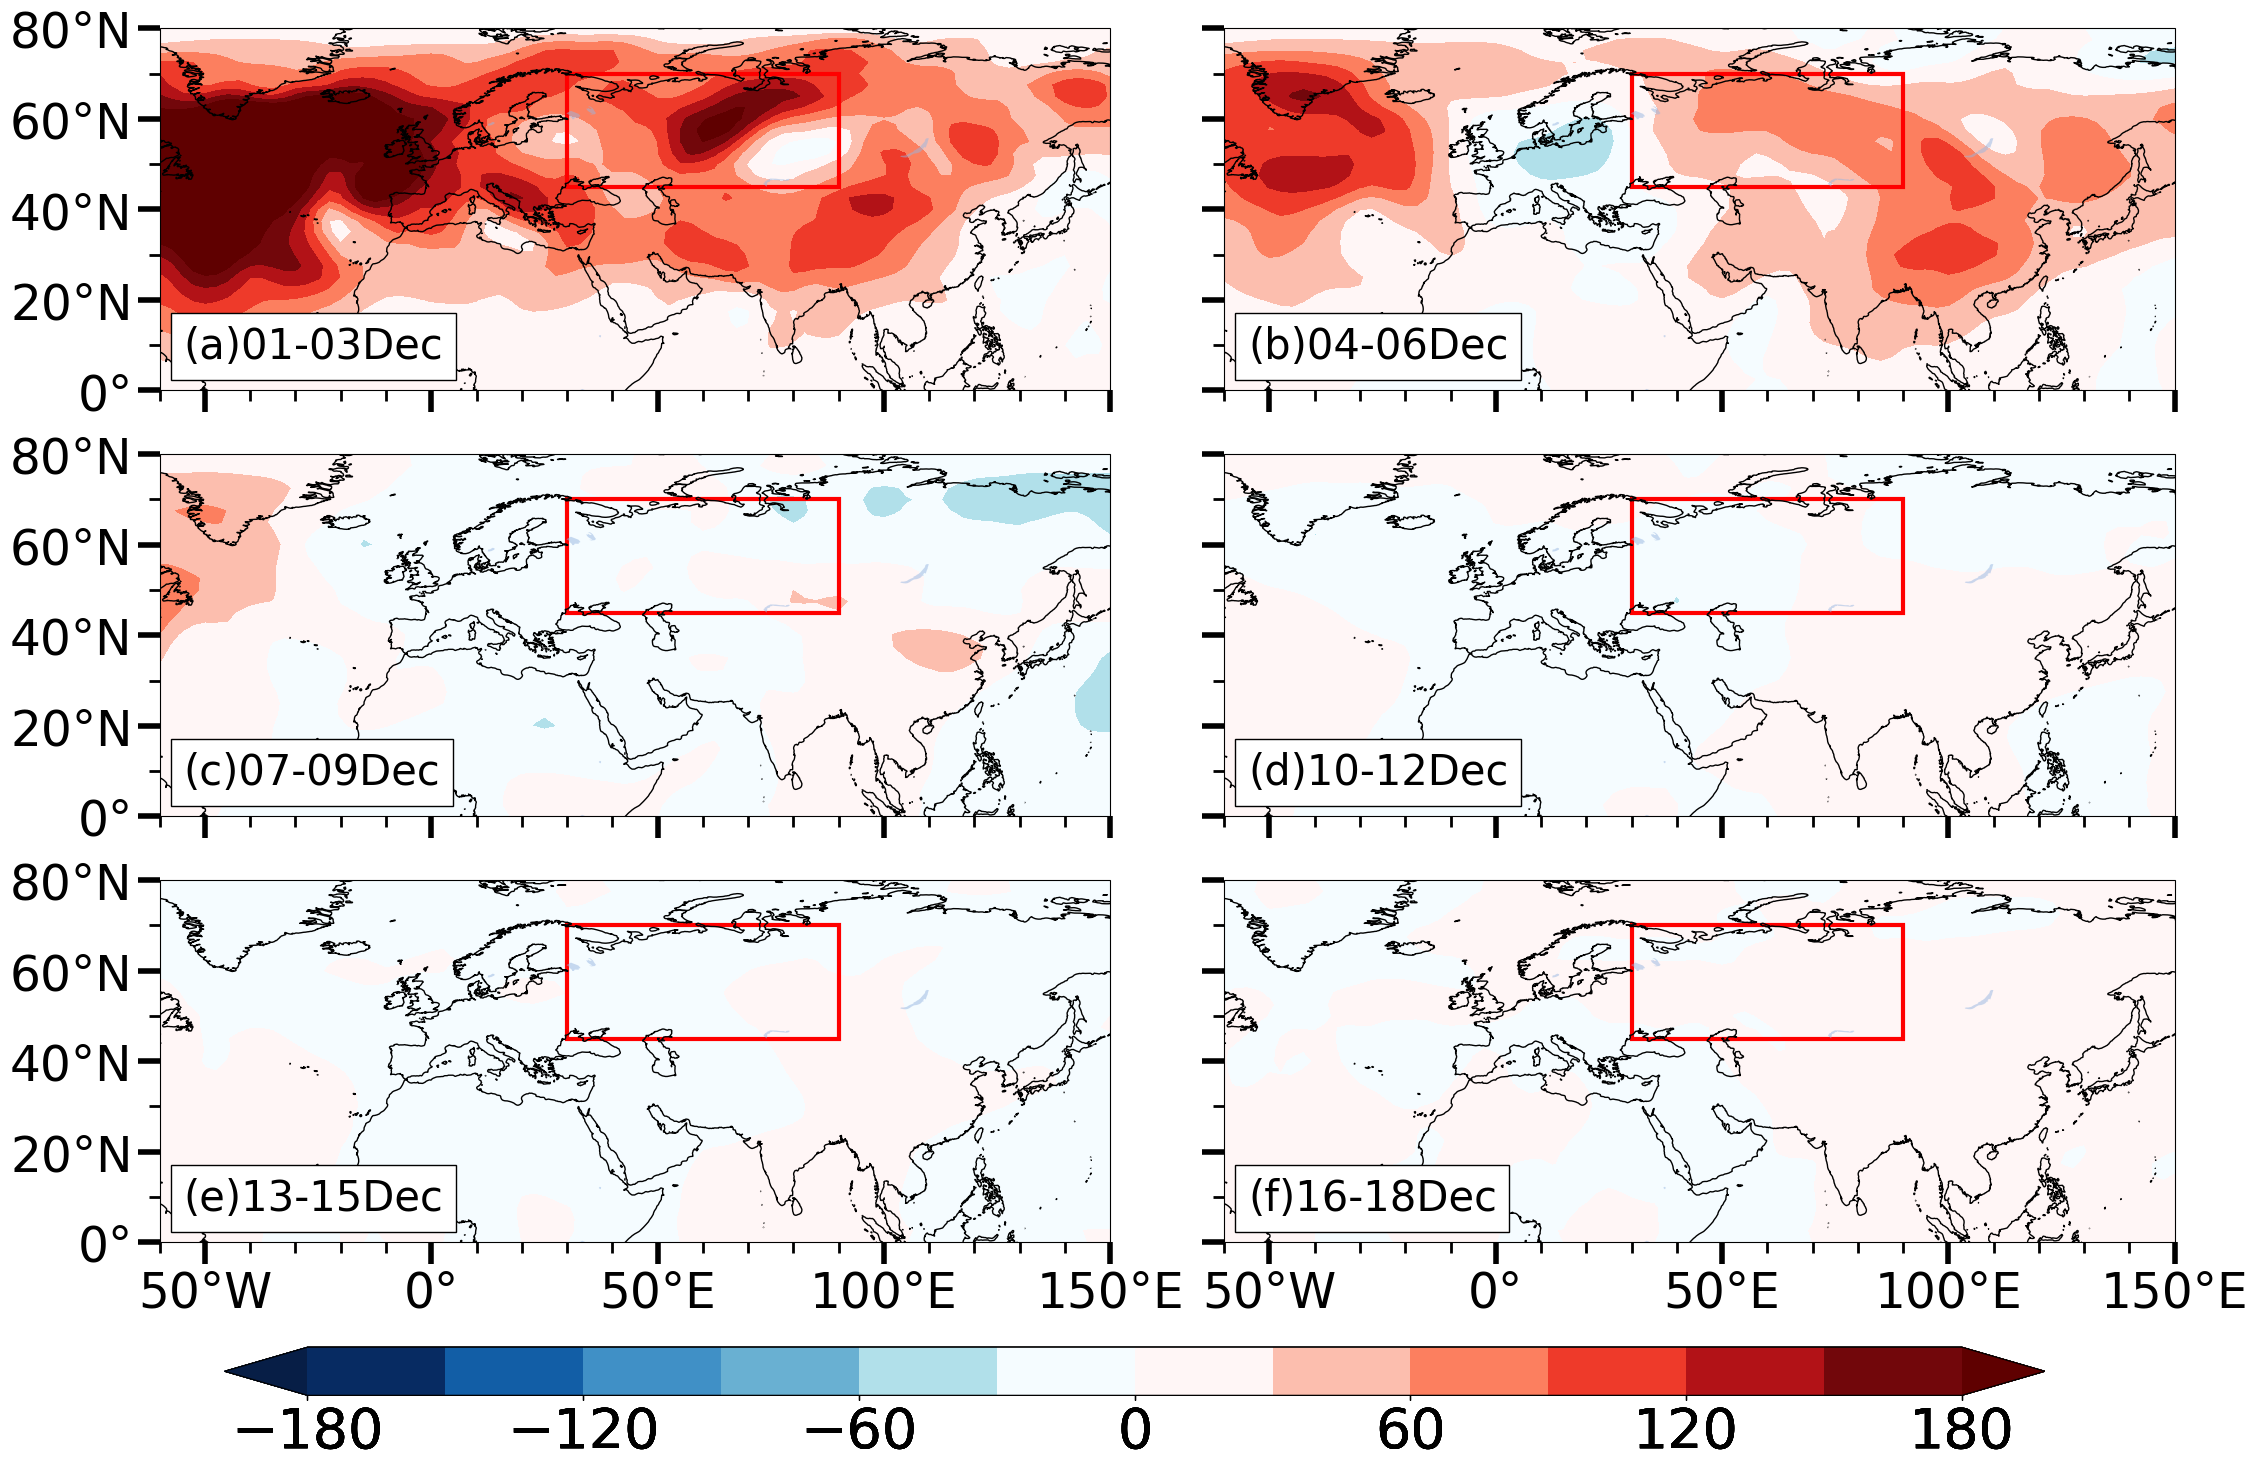

In [94]:
text_forecast_date=['01-03Dec','04-06Dec','07-09Dec','10-12Dec','13-15Dec','16-18Dec']
# text_forecast_date=['18-20Nov','21-23Nov','24-26Nov','27-29Nov','30Nov-02Dec','03-05Dec','06-08Dec']
# text_forecast_date=['10-12Dec','13-15Dec','16-18Dec','19-21Dec','22-24Dec','25-27Dec','28-30Dec']
# text_forecast_date=['06-08Dec','09Dec-11Dec','12-14Dec','15-17Dec','18-20Dec','21-23Dec','24-26Dec','27-29Dec']
ft_index=2
fig=plt.figure(figsize=(26,16))
plt.subplots_adjust(wspace=0.12,hspace=0.12)
for i in range(6):
    ax = fig.add_subplot(3,2,i+1,projection = ccrs.PlateCarree())
    text='('+chr(ord('a') + i)+')'+text_forecast_date[i]
    props = dict(boxstyle="square,pad=0.3",edgecolor="black", facecolor="white", alpha=1)  # 设置文本框样式  pad=0.2为字体距边框距离
    ax.text(
        0.025, 0.18,  # 文本框位置（相对坐标，左下角）
        text,
        fontsize=30,  # 字体大小
        color="black",  # 字体颜色
        bbox=props,
        transform=ax.transAxes,  # 使用相对坐标
        verticalalignment="top",  # 垂直对齐方式，顶部对齐
        horizontalalignment="left",  # 水平对齐方式，左对齐
        zorder=2
    )
    ax.add_feature(cfeature.COASTLINE.with_scale('50m')) 
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.set_xticks(np.array([20,60,100,140,180]), crs=ccrs.PlateCarree())
    ax.set_yticks(np.array([20,40,60,80]), crs=ccrs.PlateCarree())
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.xaxis.set_major_locator(FixedLocator(np.arange(-50,151,50)))    
    ax.xaxis.set_minor_locator(MultipleLocator(10)) 
    ax.yaxis.set_major_locator(FixedLocator(np.arange(0,81,20)))    
    ax.yaxis.set_minor_locator(MultipleLocator(10)) 
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis="x", which="major", direction="out", width=4, length=16,labelsize=35)
    ax.tick_params(axis='x', which="minor", direction="out", width=2, length=8)
    ax.tick_params(axis="y", which="major", direction="out", width=4, length=16,labelsize=35)
    ax.tick_params(axis='y', which="minor", direction="out", width=2, length=8)
    if i>3:
        ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    if i % 2==0:
        ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    cs.draw_rectangle(30,90,45,70,ax)
    # black_rectangle(1,60,21,50,ax)
    import cmaps
    cmap1=cmaps.BlueWhiteOrangeRed
    cmap=cmaps.BlueYellowRed
    temperature_cmap = cmaps.temp_19lev
    # 获取该色图的颜色
    colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))
    
    # 让中间两个颜色成为白色
    midpoint = len(colors) // 2  # 找到色图的中间位置
    colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色
    
    # 创建新的色图
    new_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)
    lon=np.arange(-60,151,2.5)
    lat=np.arange(0,81,2.5)
    c1 = ax.contourf(lon,lat, vor_f_ECMWF[ft_index][3*i:3*(i+1)].mean(dim='time'), zorder=0,levels =np.arange(-180,181,30) ,
                         transform=ccrs.PlateCarree(), cmap=new_cmap,extend='both')
    # C2 = ax.contour(lon,lat, Z_ano_all_event, zorder=0,levels =np.arange(-160,0,10),linestyles='--',colors='black',linewidths=2)
    # C3 = ax.contour(lon,lat, Z_ano_all_event, zorder=0,levels =np.arange(10,161,10),linestyles='-',colors='black',linewidths=2)
    
    position=fig.add_axes([0.15, 0.02,  0.7, 0.03])
    cb = plt.colorbar(c1,cax=position,fraction=0.032, pad=0.2,orientation='horizontal')
    cb.ax.tick_params(labelsize=40)
    cb.set_ticks(np.arange(-180,181,60))
    
cs.mkdir_directory(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast\\'+event_forecast_date[ft_index]+'.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast\\'+event_forecast_date[ft_index]+'.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast\\'+event_forecast_date[ft_index]+'.eps',dpi=300,bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


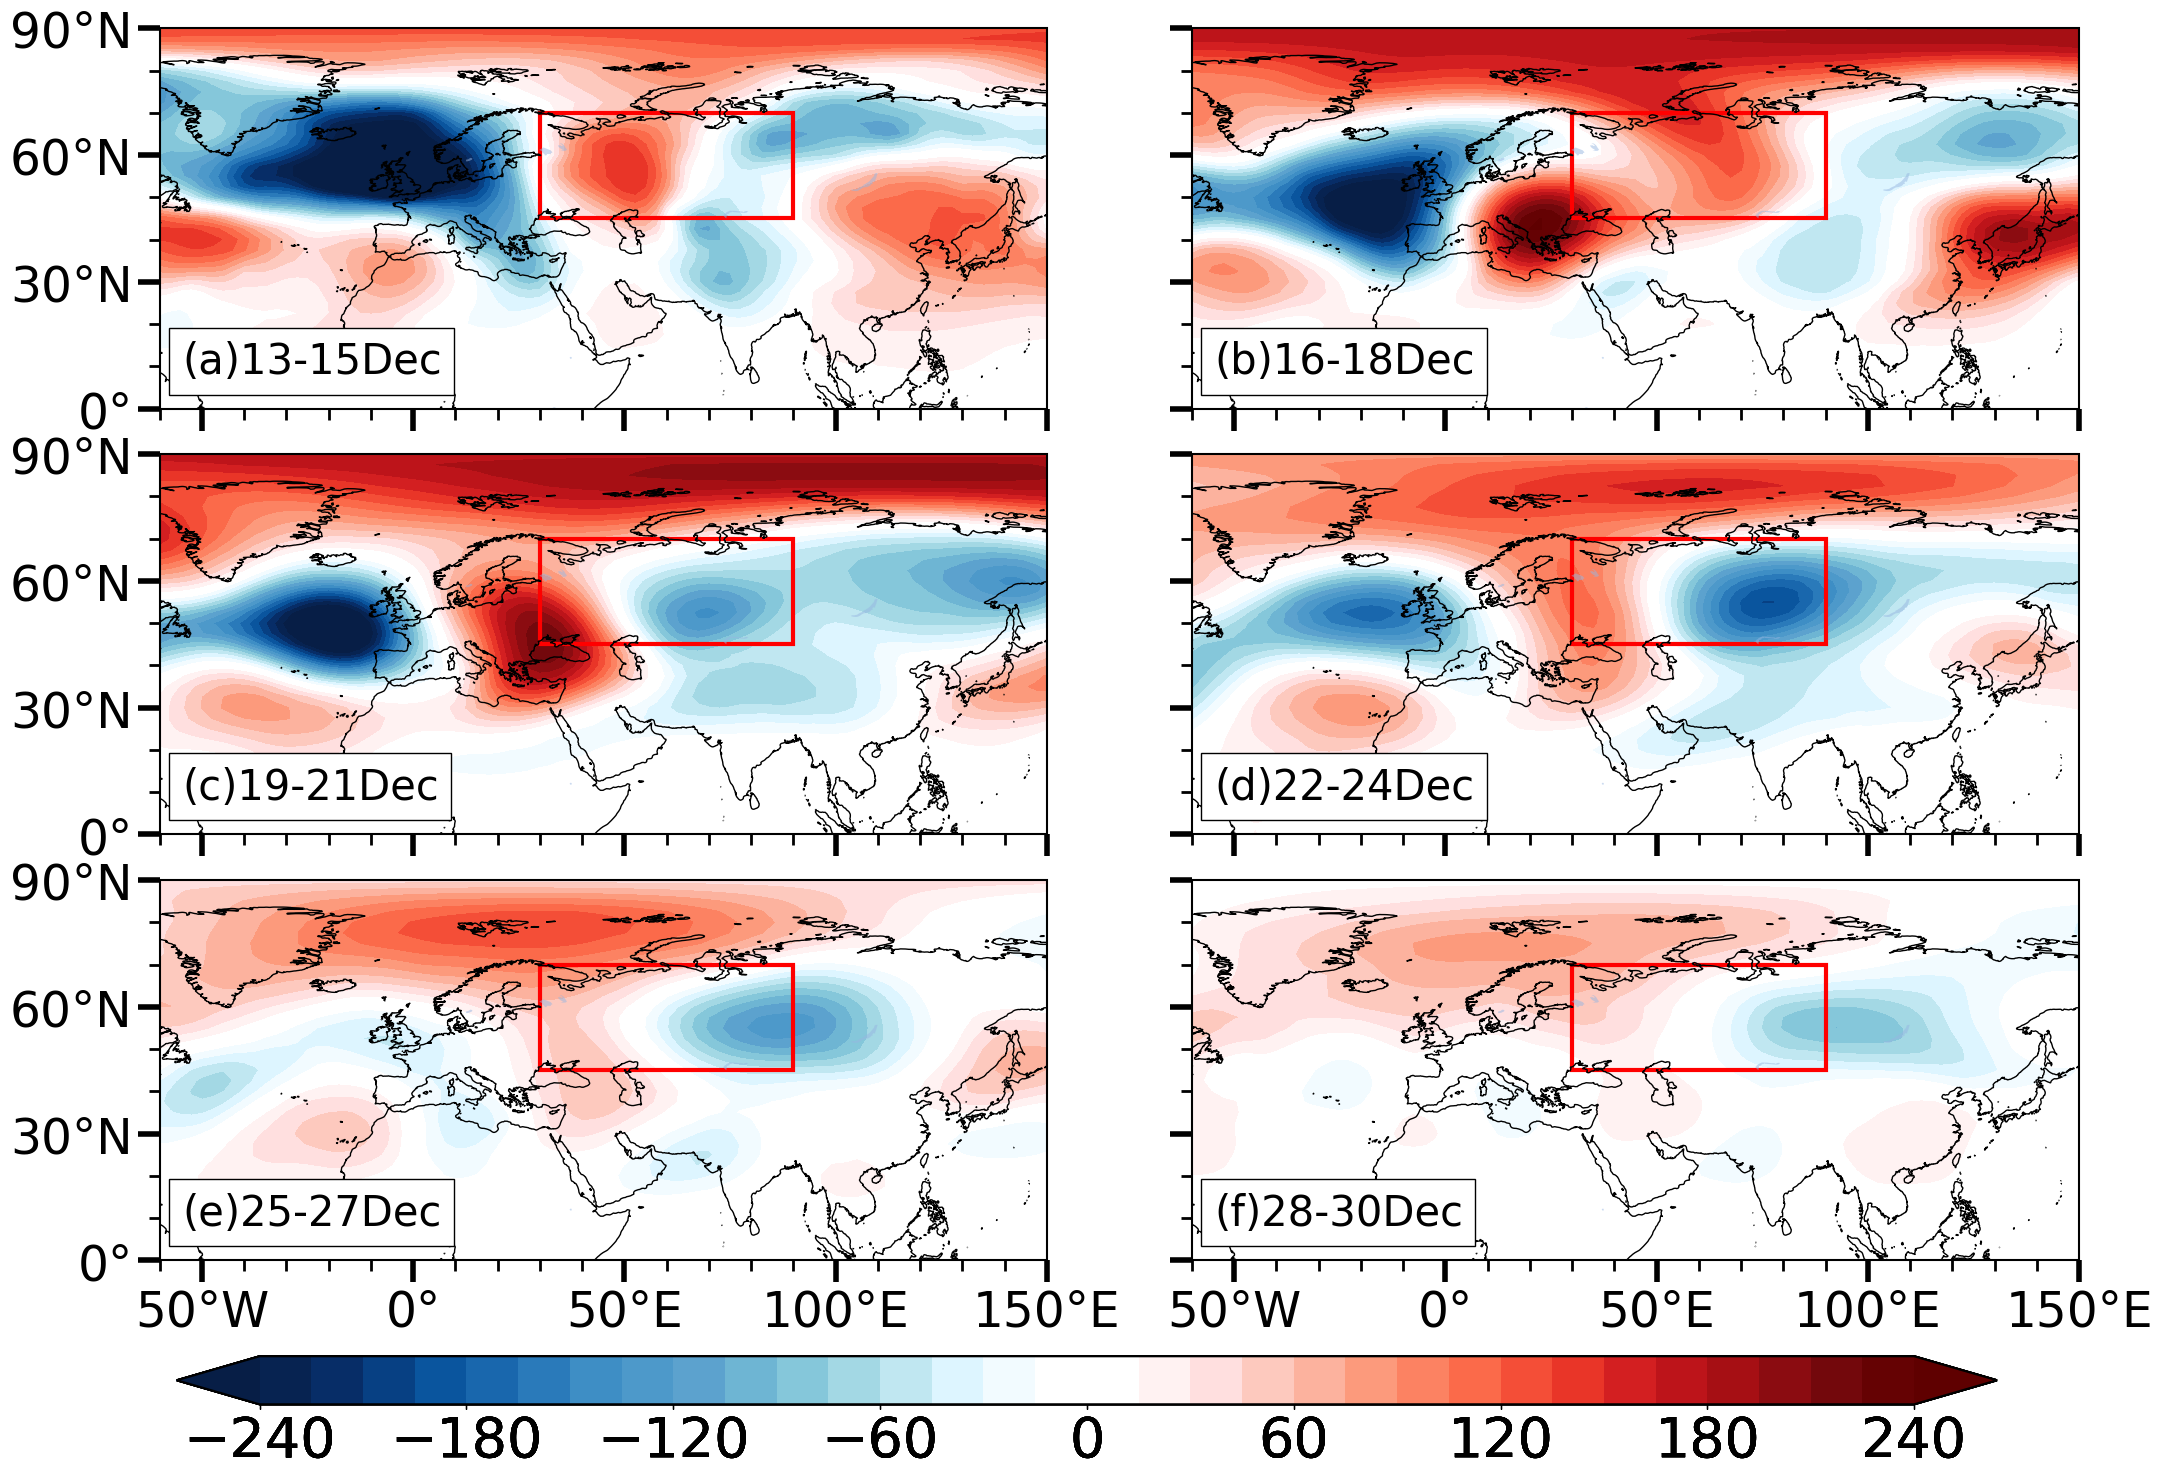

In [59]:
text_forecast_date=['25-27Nov','28-30Nov','01-03Dec','04-06Dec','07-09Dec','10-12Dec','13-15Dec','16-18Dec']
# text_forecast_date=['21-23Nov','24-26Nov','27-29Nov','30Nov-02Dec','03-05Dec','06-08Dec']
# text_forecast_date=['13-15Dec','16-18Dec','19-21Dec','22-24Dec','25-27Dec','28-30Dec']
# text_forecast_date=['06-08Dec','09-11Dec','12-14Dec','15-17Dec','18-20Dec','21-23Dec','24-26Dec','27-29Dec']
ft_index=1
fig=plt.figure(figsize=(26,16))
plt.subplots_adjust(wspace=0.05,hspace=0.12)
for i in range(6):
    ax = fig.add_subplot(3,2,i+1,projection = ccrs.PlateCarree())
    text='('+chr(ord('a') + i)+')'+text_forecast_date[i]
    props = dict(boxstyle="square,pad=0.3",edgecolor="black", facecolor="white", alpha=1)  # 设置文本框样式  pad=0.2为字体距边框距离
    ax.text(
        0.025, 0.18,  # 文本框位置（相对坐标，左下角）
        text,
        fontsize=30,  # 字体大小
        color="black",  # 字体颜色
        bbox=props,
        transform=ax.transAxes,  # 使用相对坐标
        verticalalignment="top",  # 垂直对齐方式，顶部对齐
        horizontalalignment="left",  # 水平对齐方式，左对齐
        zorder=2
    )
    ax.add_feature(cfeature.COASTLINE.with_scale('50m')) 
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.set_xticks(np.array([20,60,100,140,180]), crs=ccrs.PlateCarree())
    ax.set_yticks(np.array([20,40,60,80]), crs=ccrs.PlateCarree())
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.xaxis.set_major_locator(FixedLocator(np.arange(-50,151,50)))    
    ax.xaxis.set_minor_locator(MultipleLocator(10)) 
    ax.yaxis.set_major_locator(FixedLocator(np.arange(0,91,30)))    
    ax.yaxis.set_minor_locator(MultipleLocator(10)) 
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis="x", which="major", direction="out", width=4, length=16,labelsize=35)
    ax.tick_params(axis='x', which="minor", direction="out", width=2, length=8)
    ax.tick_params(axis="y", which="major", direction="out", width=4, length=16,labelsize=35)
    ax.tick_params(axis='y', which="minor", direction="out", width=2, length=8)
    if i>3:
        ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    if i % 2==0:
        ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    cs.draw_rectangle(30,90,45,70,ax)
    # black_rectangle(1,60,21,50,ax)
    import cmaps
    cmap1=cmaps.BlueWhiteOrangeRed
    cmap=cmaps.BlueYellowRed
    temperature_cmap = cmaps.temp_19lev
    # 获取该色图的颜色
    colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))
    
    # 让中间两个颜色成为白色
    midpoint = len(colors) // 2  # 找到色图的中间位置
    colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色
    
    # 创建新的色图
    new_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)
    lon=np.arange(-60,151,2.5)
    lat=np.arange(0,91,2.5)
    c1 = ax.contourf(lon,lat, Z_ano_forecast_all_event[ft_index][3*i+1:3*(i+1)+1].mean(dim='step').mean(dim='number').sel(longitude=slice(-60,150),latitude=slice(0,90)),zorder=0,levels =np.arange(-240,241,15),transform=ccrs.PlateCarree(), cmap=new_cmap,extend='both')
    # C2 = ax.contour(lon,lat, Z_ano_all_event, zorder=0,levels =np.arange(-160,0,10),linestyles='--',colors='black',linewidths=2)
    # C3 = ax.contour(lon,lat, Z_ano_all_event, zorder=0,levels =np.arange(10,161,10),linestyles='-',colors='black',linewidths=2)
    
    position=fig.add_axes([0.15, 0.02,  0.7, 0.03])
    cb = plt.colorbar(c1,cax=position,fraction=0.032, pad=0.2,orientation='horizontal')
    cb.ax.tick_params(labelsize=40)
    cb.set_ticks(np.arange(-240,241,60))
    
cs.mkdir_directory(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast\\'+event_forecast_date[ft_index]+'.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast\\'+event_forecast_date[ft_index]+'.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast\\'+event_forecast_date[ft_index]+'.eps',dpi=300,bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


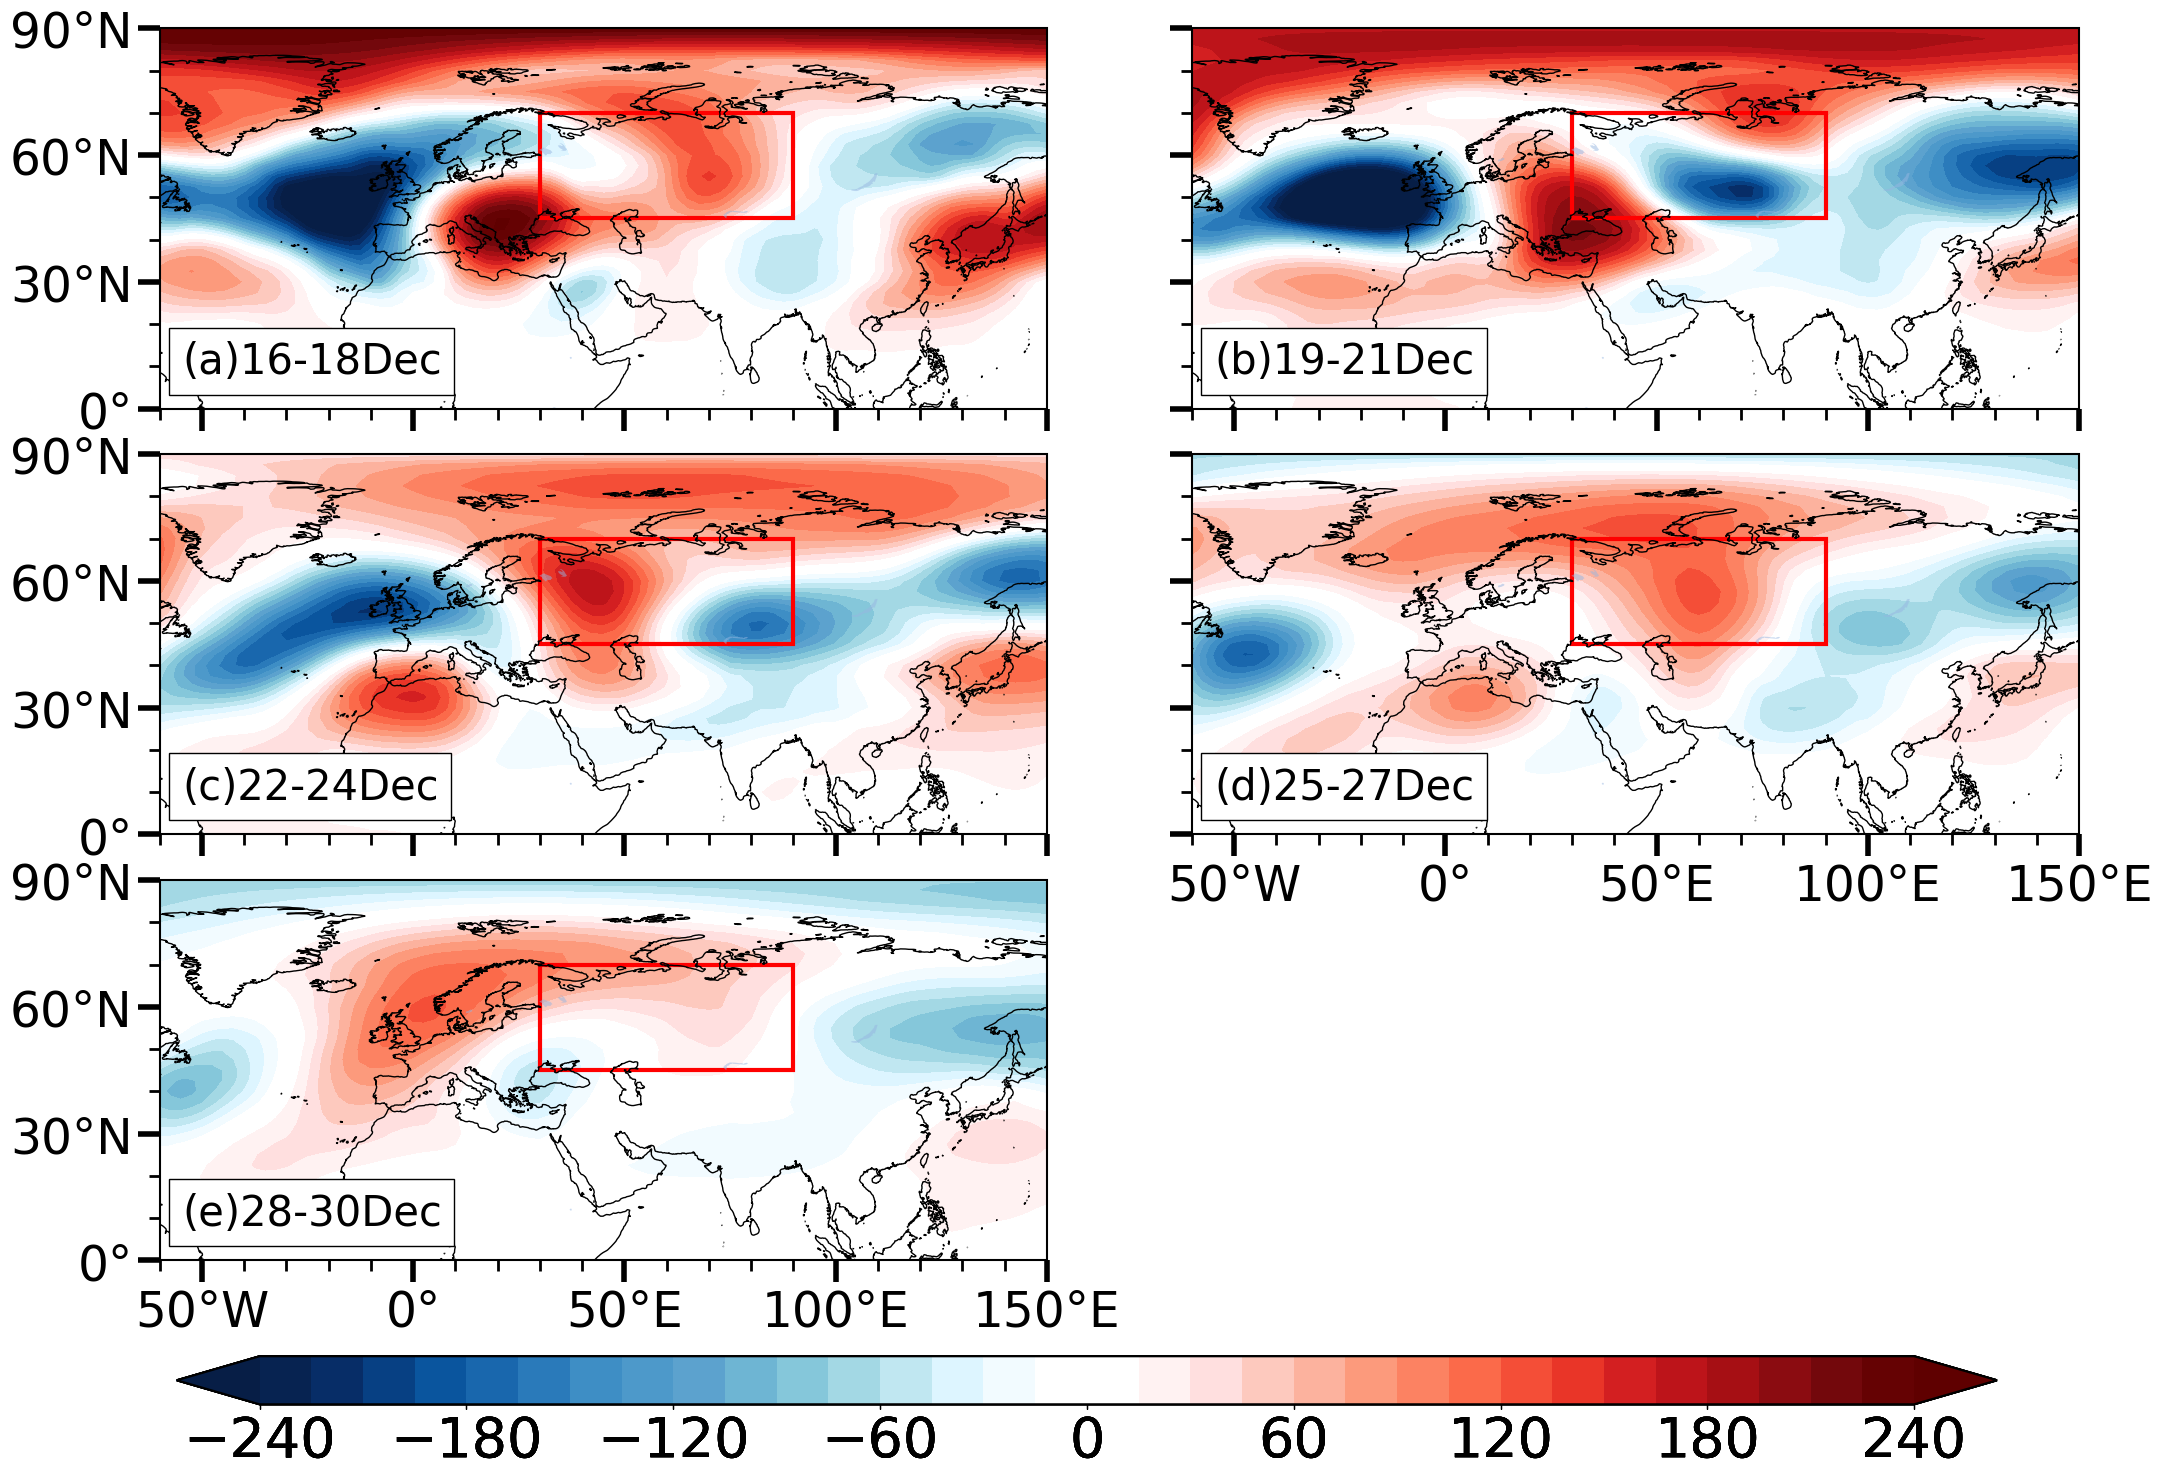

In [60]:
text_forecast_date=['25-27Nov','28-30Nov','01-03Dec','04-06Dec','07-09Dec','10-12Dec','13-15Dec','16-18Dec']
# text_forecast_date=['24-26Nov','27-29Nov','30Nov-02Dec','03-05Dec','06-08Dec']
# text_forecast_date=['16-18Dec','19-21Dec','22-24Dec','25-27Dec','28-30Dec']
# text_forecast_date=['06-08Dec','09-11Dec','12-14Dec','15-17Dec','18-20Dec','21-23Dec','24-26Dec','27-29Dec']
ft_index=4
fig=plt.figure(figsize=(26,16))
plt.subplots_adjust(wspace=0.05,hspace=0.12)
for i in range(5):
    ax = fig.add_subplot(3,2,i+1,projection = ccrs.PlateCarree())
    text='('+chr(ord('a') + i)+')'+text_forecast_date[i]
    props = dict(boxstyle="square,pad=0.3",edgecolor="black", facecolor="white", alpha=1)  # 设置文本框样式  pad=0.2为字体距边框距离
    ax.text(
        0.025, 0.18,  # 文本框位置（相对坐标，左下角）
        text,
        fontsize=30,  # 字体大小
        color="black",  # 字体颜色
        bbox=props,
        transform=ax.transAxes,  # 使用相对坐标
        verticalalignment="top",  # 垂直对齐方式，顶部对齐
        horizontalalignment="left",  # 水平对齐方式，左对齐
        zorder=2
    )
    ax.add_feature(cfeature.COASTLINE.with_scale('50m')) 
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.set_xticks(np.array([20,60,100,140,180]), crs=ccrs.PlateCarree())
    ax.set_yticks(np.array([20,40,60,80]), crs=ccrs.PlateCarree())
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.xaxis.set_major_locator(FixedLocator(np.arange(-50,151,50)))    
    ax.xaxis.set_minor_locator(MultipleLocator(10)) 
    ax.yaxis.set_major_locator(FixedLocator(np.arange(0,91,30)))    
    ax.yaxis.set_minor_locator(MultipleLocator(10)) 
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis="x", which="major", direction="out", width=4, length=16,labelsize=35)
    ax.tick_params(axis='x', which="minor", direction="out", width=2, length=8)
    ax.tick_params(axis="y", which="major", direction="out", width=4, length=16,labelsize=35)
    ax.tick_params(axis='y', which="minor", direction="out", width=2, length=8)
    if i>2:
        ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    if i % 2==0:
        ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    cs.draw_rectangle(30,90,45,70,ax)
    # black_rectangle(1,60,21,50,ax)
    import cmaps
    cmap1=cmaps.BlueWhiteOrangeRed
    cmap=cmaps.BlueYellowRed
    temperature_cmap = cmaps.temp_19lev
    # 获取该色图的颜色
    colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))
    
    # 让中间两个颜色成为白色
    midpoint = len(colors) // 2  # 找到色图的中间位置
    colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色
    
    # 创建新的色图
    new_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)
    lon=np.arange(-60,151,2.5)
    lat=np.arange(0,91,2.5)
    c1 = ax.contourf(lon,lat, Z_ano_forecast_all_event[ft_index][3*i:3*(i+1)].mean(dim='step').mean(dim='number').sel(longitude=slice(-60,150),latitude=slice(0,90)),zorder=0,levels =np.arange(-240,241,15),transform=ccrs.PlateCarree(), cmap=new_cmap,extend='both')
    # C2 = ax.contour(lon,lat, Z_ano_all_event, zorder=0,levels =np.arange(-160,0,10),linestyles='--',colors='black',linewidths=2)
    # C3 = ax.contour(lon,lat, Z_ano_all_event, zorder=0,levels =np.arange(10,161,10),linestyles='-',colors='black',linewidths=2)
    
    position=fig.add_axes([0.15, 0.02,  0.7, 0.03])
    cb = plt.colorbar(c1,cax=position,fraction=0.032, pad=0.2,orientation='horizontal')
    cb.ax.tick_params(labelsize=40)
    cb.set_ticks(np.arange(-240,241,60))
    
cs.mkdir_directory(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast\\'+event_forecast_date[ft_index]+'.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast\\'+event_forecast_date[ft_index]+'.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event\Eddy_forcing.'+event_date+'_'+event_date_end+'forecast\\'+event_forecast_date[ft_index]+'.eps',dpi=300,bbox_inches='tight')